In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.chdir('..')

import pickle
import re
from pathlib import Path

import torch
import datasets
import numpy as np
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from transformers.modeling_outputs import CausalLMOutputWithPast

from tqdm import tqdm

from model import MemoryCell

In [2]:
pd.set_option('display.max_rows', 200)

In [3]:
import pandas as pd
# df = pd.DataFrame({'text': texts})
# df.to_csv('pg19_valid_1k_chunks.csv')
texts_df = pd.read_csv('./notebooks/pg19_valid_1k_chunks.csv', index_col=0)
texts_df.head()

,text
0,"'Let us stay here,' she exclaimed. 'The one ro..."
1,These lobsters don't realize that Jonesy's fas...
2,It certainly was not relief that he felt on di...
3,Down to 1765 the duty imposed was only one pen...
4,"And what was, perhaps, more extraordinary, tho..."


In [83]:
import json
tokens_to_bytes = json.load(open('./tokens_to_bytes.json', 'r'))

In [118]:
models = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
          'EleutherAI/pythia-2.8b',
          'allenai/OLMo-1B-0724-hf',
          'princeton-nlp/Sheared-LLaMA-1.3B',
          'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B']
N_mem_tokens = 1

data = []
from pathlib import Path
for model_name in tqdm(models):
    cfg = AutoConfig.from_pretrained(model_name)
    getattr(cfg, 'num_hidden_layers')
    load_path = Path(f'./runs/{model_name}/')
    for file_path in load_path.glob(f'mem_{N_mem_tokens}_len_*.pkl'):
        if file_path.is_file():
            # Extract max_length from the file name using regex
            match = re.search(f'mem_{N_mem_tokens}_len_(\d+)(_rnd_vocab_100k)?\.pkl', file_path.name)
            if match:
                max_length = int(match.group(1))
            else:
                continue
            
            try:
                with open(file_path, 'rb') as f:
                    d = pickle.load(f)
            except Exception as e:
                continue

        try:
            d = pickle.load(open(file_path, 'rb'))
        except:
            continue
        for el in d:
            data += [{
                'model_name': model_name,
                'max_length': el['max_length'],
                'n_mem_tokens': el['n_mem_tokens'],
                'original_loss': el['original_loss'],
                'best_loss': np.min(el['losses'][:5000]),#el['best_loss'],
                'best_accuracy': np.max(el['accuracies'][:5000]),#el['best_accuracy'],#np.max(el['accuracies'][:5000]), #
                'shuffled': el['args'].get('shuffled', False),
                'mem_dim': el['best_memory_params'].shape[-1],
                'n_layers': getattr(cfg, 'num_hidden_layers'),
                'vocab_size': getattr(cfg, 'vocab_size'),
                'n_att_heads': getattr(cfg, 'num_attention_heads'),
                'intermediate_size': getattr(cfg, 'intermediate_size'),
                'token2bytes': tokens_to_bytes.get(model_name)
            }]
all_models_df = pd.DataFrame(data)

100%|██████████| 9/9 [00:25<00:00,  2.79s/it]


In [119]:
# PYTHIA-410m rnd text -- only 5k steps with es 2000

In [120]:
all_models_df[all_models_df['model_name'] == 'EleutherAI/pythia-160m']

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,mem_dim,n_layers,vocab_size,n_att_heads,intermediate_size,token2bytes
0,EleutherAI/pythia-160m,8,1,4.882830,0.261007,1.000000,False,768,12,50304,12,3072,0.231407
1,EleutherAI/pythia-160m,8,1,6.018319,0.304136,1.000000,False,768,12,50304,12,3072,0.231407
2,EleutherAI/pythia-160m,8,1,3.802093,0.751129,1.000000,False,768,12,50304,12,3072,0.231407
3,EleutherAI/pythia-160m,8,1,4.751411,0.964425,1.000000,False,768,12,50304,12,3072,0.231407
4,EleutherAI/pythia-160m,8,1,5.125309,0.491976,1.000000,False,768,12,50304,12,3072,0.231407
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,EleutherAI/pythia-160m,63,1,7.105629,0.211077,1.000000,True,768,12,50304,12,3072,0.231407
596,EleutherAI/pythia-160m,160,1,7.331276,4.111260,0.433962,True,768,12,50304,12,3072,0.231407
597,EleutherAI/pythia-160m,214,1,7.020869,4.577562,0.389671,True,768,12,50304,12,3072,0.231407
598,EleutherAI/pythia-160m,242,1,6.673029,4.550960,0.336100,True,768,12,50304,12,3072,0.231407


In [57]:
model_name = 'EleutherAI/pythia-160m'
# model_name = 'princeton-nlp/Sheared-LLaMA-1.3B'
# model_name = 'princeton-nlp/Sheared-LLaMA-1.3B'
tokenizer = AutoTokenizer.from_pretrained(model_name)
N_mem_tokens = 1

from nltk import sent_tokenize
text_sample = texts_df['text'][0]
sentences = sent_tokenize(text_sample)
prefix_text = ' '.join(sentences[:len(sentences)//2])
suffix_text = ' '.join(sentences[len(sentences)//2:])

inp = tokenizer(suffix_text, max_length=16, truncation=True)
inp

/home/jovyan/envs/py3.11_pt2_cu11.8/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{'input_ids': [8389, 2927, 1313, 1110, 273, 17145, 2327, 13, 665, 369, 7725, 8855, 327, 253, 643, 1930], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [58]:
df = all_models_df[all_models_df['model_name'] == model_name]
df

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,mem_dim,n_layers,vocab_size,n_att_heads
0,EleutherAI/pythia-160m,8,1,4.882830,0.261007,1.000000,False,768,12,50304,12
1,EleutherAI/pythia-160m,8,1,6.018319,0.304136,1.000000,False,768,12,50304,12
2,EleutherAI/pythia-160m,8,1,3.802093,0.751129,1.000000,False,768,12,50304,12
3,EleutherAI/pythia-160m,8,1,4.751411,0.964425,1.000000,False,768,12,50304,12
4,EleutherAI/pythia-160m,8,1,5.125309,0.491976,1.000000,False,768,12,50304,12
...,...,...,...,...,...,...,...,...,...,...,...
595,EleutherAI/pythia-160m,63,1,7.105629,0.211077,1.000000,True,768,12,50304,12
596,EleutherAI/pythia-160m,160,1,7.331276,4.111260,0.433962,True,768,12,50304,12
597,EleutherAI/pythia-160m,214,1,7.020869,4.577562,0.389671,True,768,12,50304,12
598,EleutherAI/pythia-160m,242,1,6.673029,4.550960,0.336100,True,768,12,50304,12


/tmp/ipykernel_3411812/1422596654.py:36: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(polynomial, x_data, y_data)
/tmp/ipykernel_3411812/1422596654.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))


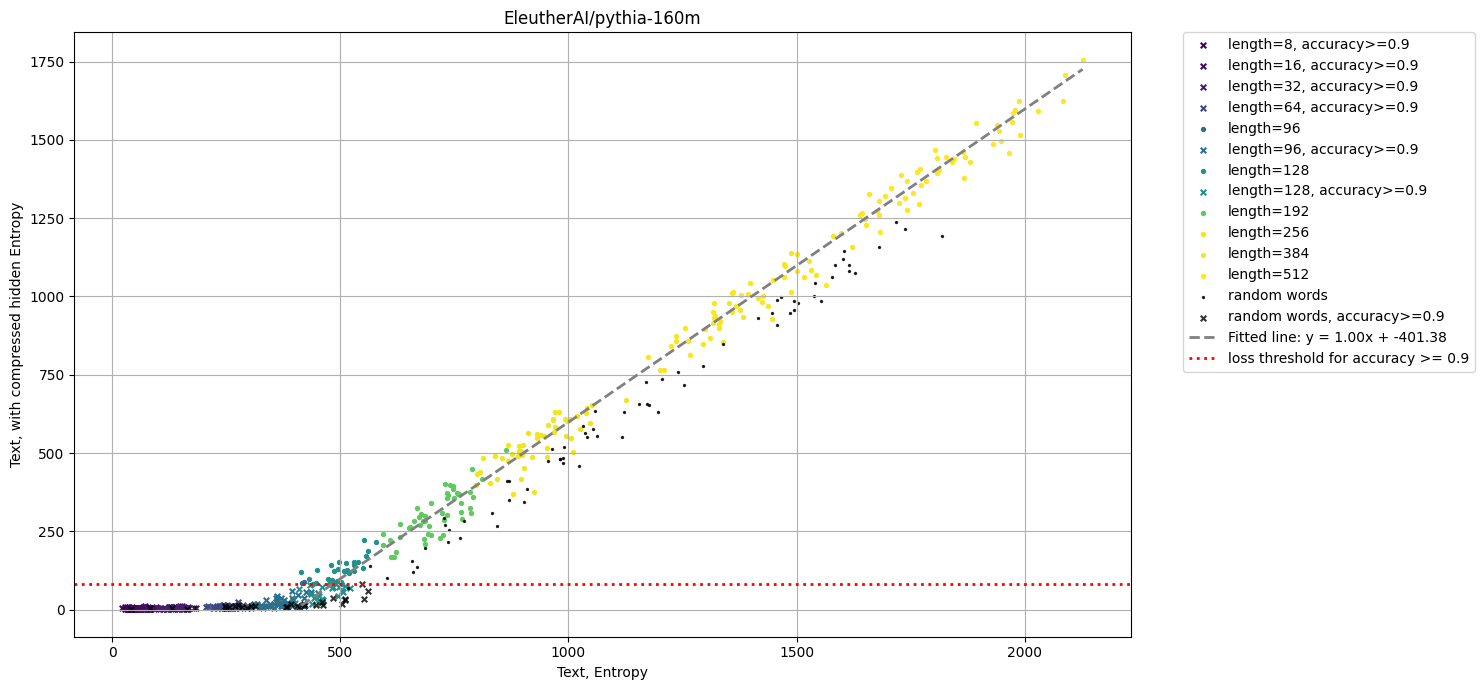

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd

import seaborn as sns
sns.reset_defaults()

model_name = 'EleutherAI/pythia-160m'
# model_name = 'princeton-nlp/Sheared-LLaMA-1.3B'
# model_name = 'EleutherAI/pythia-410m'
# model_name = 'meta-llama/Meta-Llama-3.1-8B'

# Assume `df` is a pandas DataFrame with columns: max_length, n_mem_tokens, original_loss, best_loss, best_accuracy, length

# Define a polynomial function for fitting (let's try a quadratic fit)
def polynomial(x, a, b):
    return 1 * x + b

s = 8
alpha=0.8
acc_thr = 0.9

model_df = all_models_df[all_models_df['model_name'] == model_name]
df = model_df[model_df['shuffled'] == False]

# Split data based on best_accuracy threshold
d_below_thr = df[df['best_accuracy'] < acc_thr]
d_above_thr = df[df['best_accuracy'] >= acc_thr]

# Extract data for fitting
x_data = d_below_thr['original_loss'] * d_below_thr['max_length']
y_data = d_below_thr['best_loss'] * d_below_thr['max_length']

# Use curve_fit to fit the polynomial function to the data
params, _ = curve_fit(polynomial, x_data, y_data)
a, b = params

# Generate values for the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 500)
y_fit = polynomial(x_fit, *params)

# Define a colormap to assign consistent colors to each unique max_length
max_lengths = sorted(model_df['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

plt.figure(figsize=(15, 7))

# Plot data points, grouped by max_length
for max_length in max_lengths:
    subset_below = d_below_thr[d_below_thr['max_length'] == max_length]
    subset_above = d_above_thr[d_above_thr['max_length'] == max_length]

    # Plot points below the accuracy threshold
    if len(subset_below) > 0:
        plt.scatter(
            subset_below['original_loss'] * max_length, 
            subset_below['best_loss'] * max_length,
            label=f'length={max_length}',
            s=s if max_length != 600 else s * 20,
            marker = 'o' if max_length != 600 else 'v',
            color=global_color_map[max_length]
        )

    # Plot points above the accuracy threshold
    if len(subset_above) > 0:
        plt.scatter(
            subset_above['original_loss'] * max_length, 
            subset_above['best_loss'] * max_length,
            color=global_color_map[max_length],  # Use the same color as for the points below the threshold
            marker='x', 
            s=s * 2,
            label=f'length={max_length}, accuracy>={acc_thr}'
        )

# Highlight points where shuffled is True
shuffled_df = model_df[model_df['shuffled'] == True]
if len(shuffled_df) > 0:
    d_below_thr_shuffled = shuffled_df[shuffled_df['best_accuracy'] < acc_thr]
    d_above_thr_shuffled = shuffled_df[shuffled_df['best_accuracy'] >= acc_thr]
    if len(d_below_thr_shuffled) > 0:
        plt.scatter(
            d_below_thr_shuffled['original_loss'] * d_below_thr_shuffled['max_length'],
            d_below_thr_shuffled['best_loss'] * d_below_thr_shuffled['max_length'],
            color='black',
            marker='.',
            s=s,
            alpha=alpha,
            label='random words'
        )
    if len(d_above_thr_shuffled) > 0:
        plt.scatter(
            d_above_thr_shuffled['original_loss'] * d_above_thr_shuffled['max_length'],
            d_above_thr_shuffled['best_loss'] * d_above_thr_shuffled['max_length'],
            color='black',
            marker='x',
            s=s * 2,
            alpha=alpha,
            label=f'random words, accuracy>={acc_thr}'
        )
        

# Plot the fitted curve with formula in the legend
formula_label = f'Fitted line: y = {a:.2f}x + {b:.2f}'
plt.plot(x_fit, y_fit, color='grey', linestyle='--', linewidth=2, label=formula_label)

# Find the value of best_loss corresponding to the accuracy threshold
best_loss_thr = (d_above_thr['best_loss'] * d_above_thr['max_length']).max()

# Add a horizontal line for the best_loss threshold
plt.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'loss threshold for accuracy >= {acc_thr}')

# Labels, legend, and grid
plt.xlabel('Text, Entropy')
plt.ylabel('Text, with compressed hidden Entropy')

# Move the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title(f'{model_name}')

plt.grid()
plt.tight_layout()  # Adjust layout to accommodate the legend outside
plt.show()

/tmp/ipykernel_3411812/1176153620.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(polynomial, x_data, y_data)
/tmp/ipykernel_3411812/1176153620.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))
/tmp/ipykernel_3411812/1176153620.py:94: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


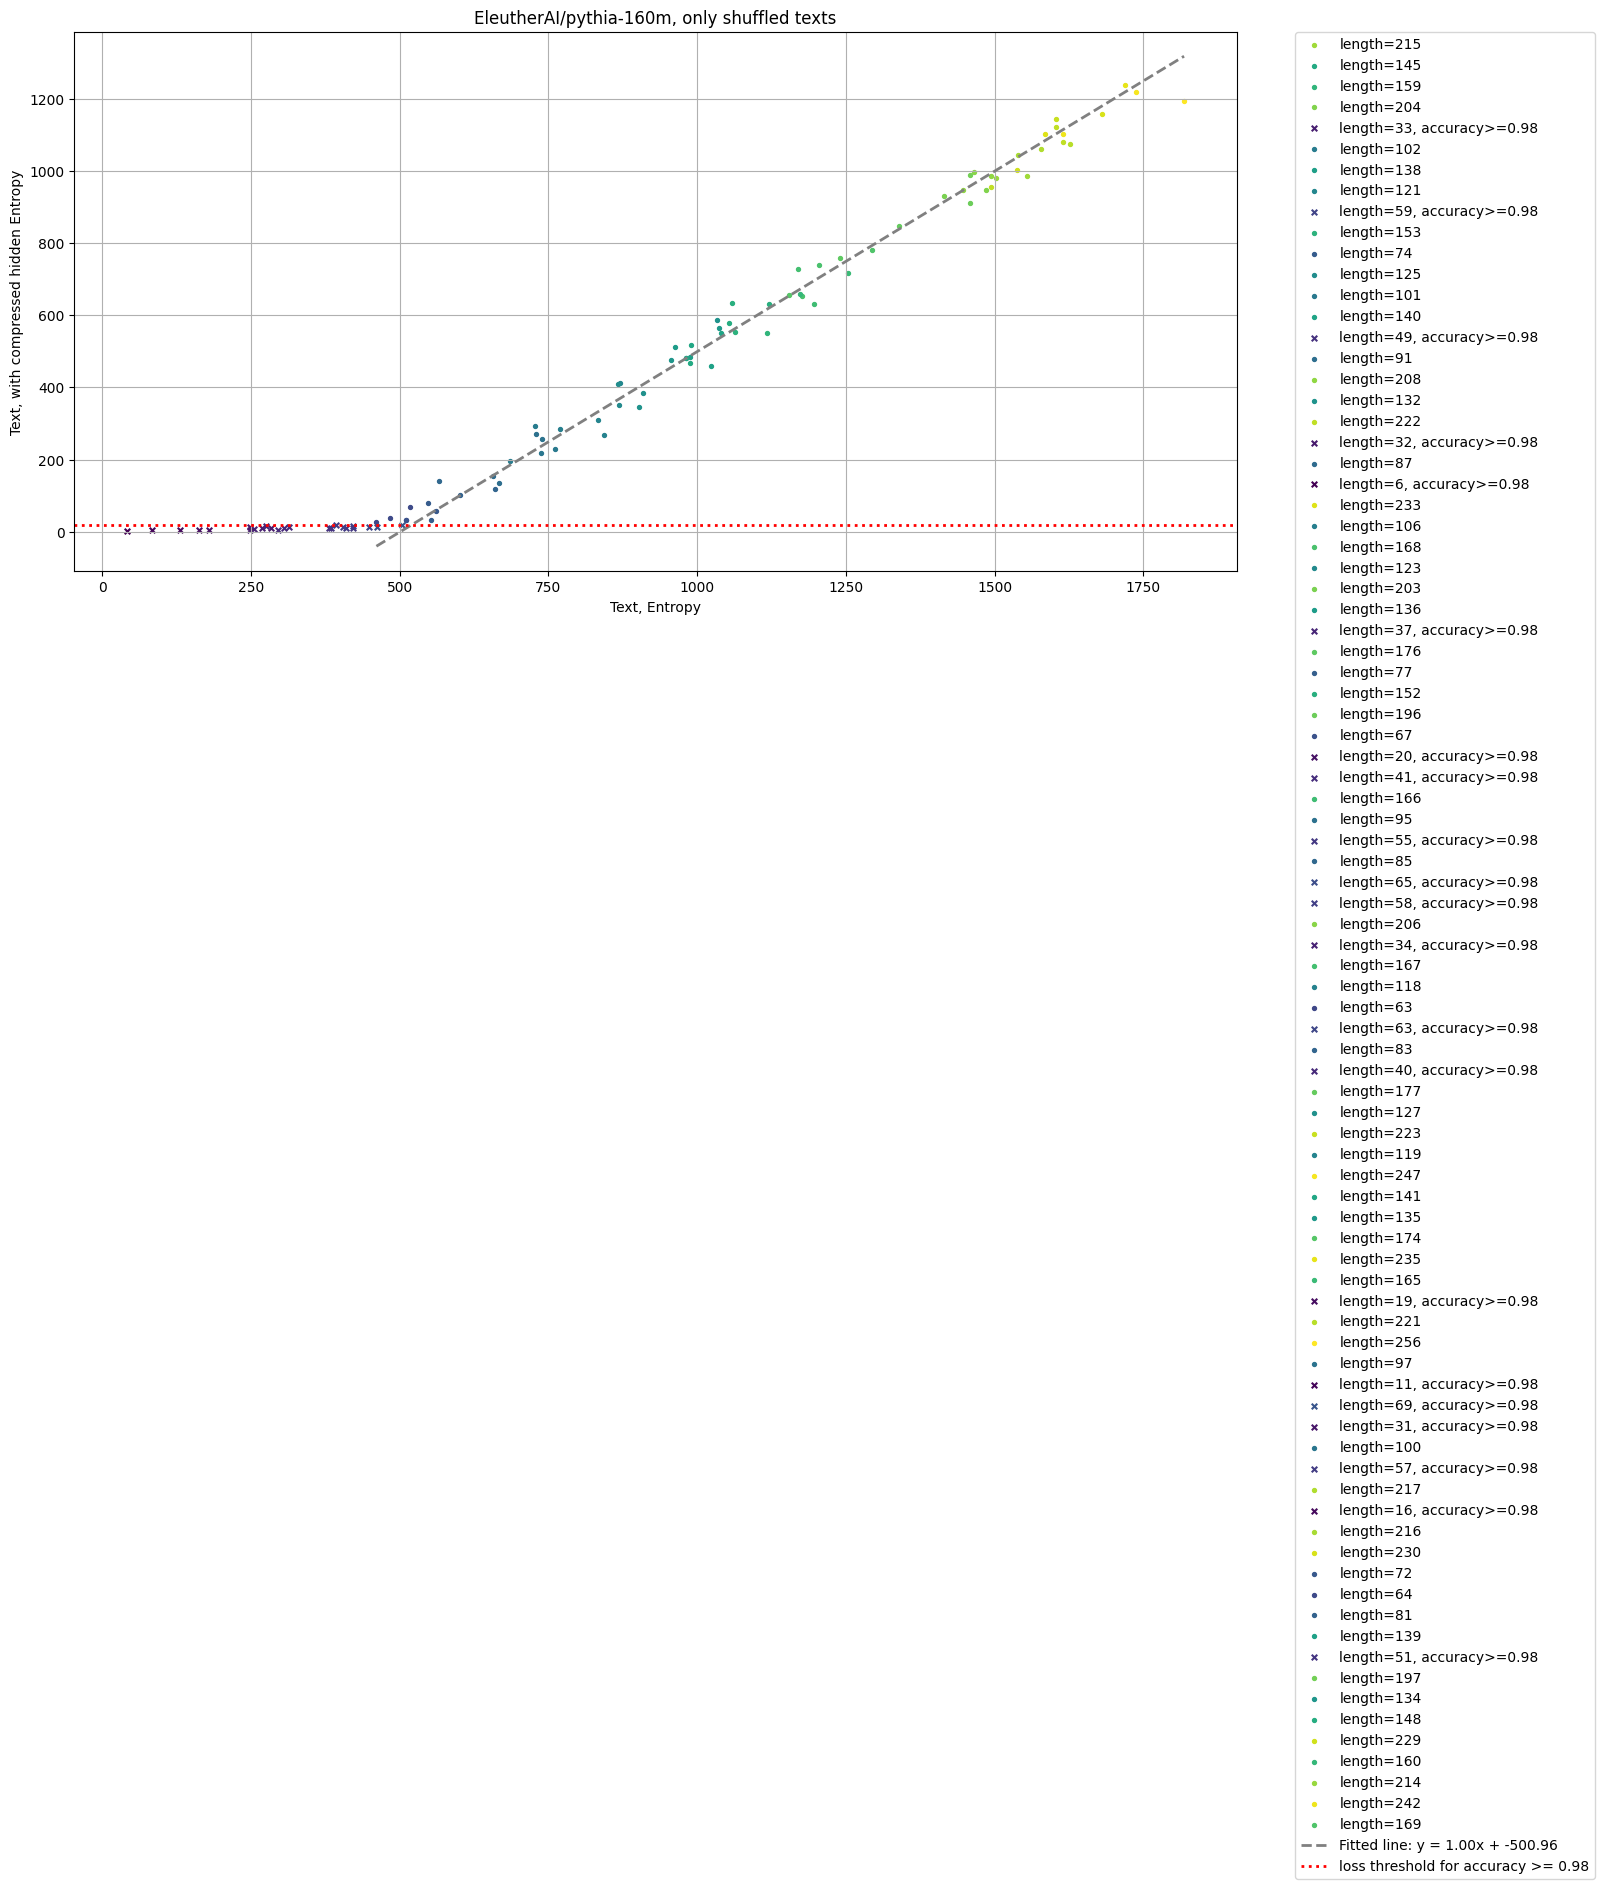

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd

import seaborn as sns
sns.reset_defaults()

model_name = 'EleutherAI/pythia-160m'
# model_name = 'princeton-nlp/Sheared-LLaMA-1.3B'

# Assume `df` is a pandas DataFrame with columns: max_length, n_mem_tokens, original_loss, best_loss, best_accuracy, length

# Define a polynomial function for fitting (let's try a quadratic fit)
def polynomial(x, a, b):
    return 1 * x + b

s = 8
alpha=0.8
acc_thr = 0.98

model_df = all_models_df[all_models_df['model_name'] == model_name]
df = model_df[model_df['shuffled'] == True]

# Split data based on best_accuracy threshold
d_below_thr = df[df['best_accuracy'] < acc_thr]
d_above_thr = df[df['best_accuracy'] >= acc_thr]

# Extract data for fitting
x_data = d_below_thr['original_loss'] * d_below_thr['max_length']
y_data = d_below_thr['best_loss'] * d_below_thr['max_length']

# Use curve_fit to fit the polynomial function to the data
params, _ = curve_fit(polynomial, x_data, y_data)
a, b = params

# Generate values for the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 500)
y_fit = polynomial(x_fit, *params)

# Define a colormap to assign consistent colors to each unique max_length
max_lengths = sorted(df['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

plt.figure(figsize=(15, 7))

# Plot data points, grouped by max_length
for max_length in df['max_length'].unique():
    subset_below = d_below_thr[d_below_thr['max_length'] == max_length]
    subset_above = d_above_thr[d_above_thr['max_length'] == max_length]

    # Plot points below the accuracy threshold
    if len(subset_below) > 0:
        plt.scatter(
            subset_below['original_loss'] * max_length, 
            subset_below['best_loss'] * max_length,
            label=f'length={max_length}',
            s=s,
            color=global_color_map[max_length]
        )

    # Plot points above the accuracy threshold
    if len(subset_above) > 0:
        plt.scatter(
            subset_above['original_loss'] * max_length, 
            subset_above['best_loss'] * max_length,
            color=global_color_map[max_length],  # Use the same color as for the points below the threshold
            marker='x', 
            s=s * 2,
            label=f'length={max_length}, accuracy>={acc_thr}'
        )

# Plot the fitted curve with formula in the legend
formula_label = f'Fitted line: y = {a:.2f}x + {b:.2f}'
plt.plot(x_fit, y_fit, color='grey', linestyle='--', linewidth=2, label=formula_label)

# Find the value of best_loss corresponding to the accuracy threshold
best_loss_thr = (d_above_thr['best_loss'] * d_above_thr['max_length']).max()

# Add a horizontal line for the best_loss threshold
plt.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'loss threshold for accuracy >= {acc_thr}')

# Labels, legend, and grid
plt.xlabel('Text, Entropy')
plt.ylabel('Text, with compressed hidden Entropy')

# Move the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title(f'{model_name}, only shuffled texts')

plt.grid()
plt.tight_layout()
plt.show()


/tmp/ipykernel_3411812/2485172282.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))


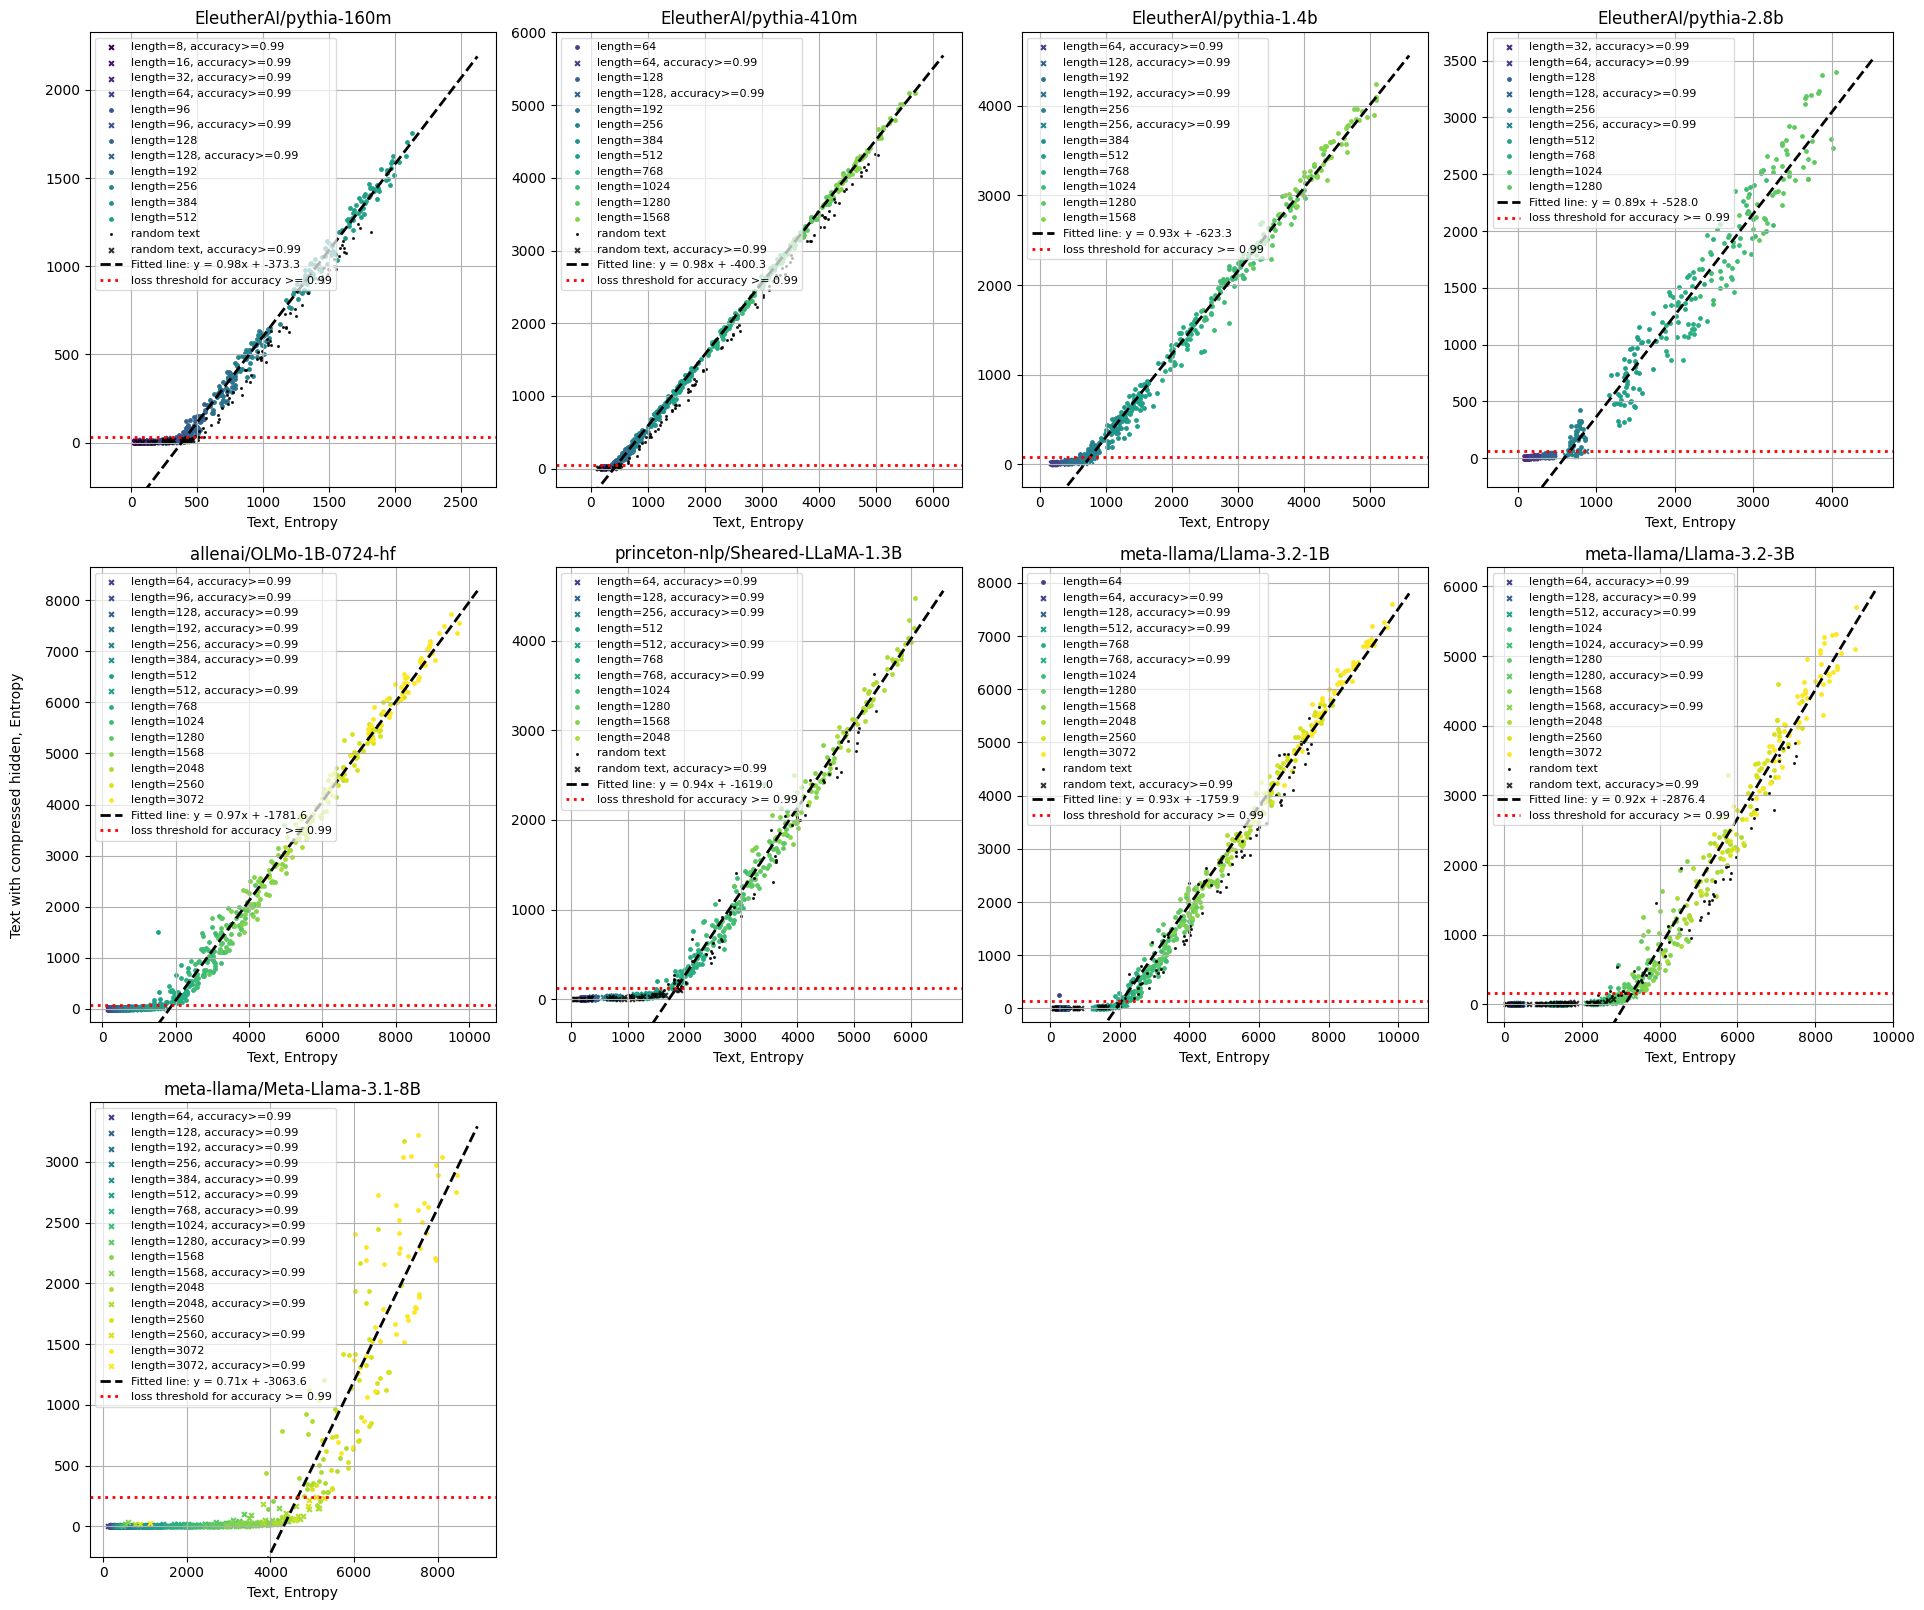

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
from transformers import AutoTokenizer

import seaborn as sns
sns.reset_defaults()

# List of models
models = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
          'EleutherAI/pythia-2.8b',
          'allenai/OLMo-1B-0724-hf',
          'princeton-nlp/Sheared-LLaMA-1.3B',
          'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B']
N_mem_tokens = 1

# Create subplots for each model
n_columns = 4
n_rows = (len(models) + n_columns - 1) // n_columns
fig, axes = plt.subplots(n_rows, n_columns, figsize=(20, 6 * n_rows),sharey=False,sharex=False)

s = 6
acc_thr = 0.99
alpha=0.8

def polynomial(x, a, b):
    return a * x + b

# Define a global color map for max_lengths
max_lengths = sorted(all_models_df[all_models_df['shuffled']==False]['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

data = []
for idx, model_name in enumerate(models):

    model_df = all_models_df[all_models_df['model_name'] == model_name]
    df = model_df[model_df['shuffled'] == False]
    if len(df) == 0:
        print(f'skipping {model_name}')
        continue

    # Split data based on best_accuracy threshold
    d_below_thr = df[df['best_accuracy'] < acc_thr]
    d_above_thr = df[df['best_accuracy'] >= acc_thr]

    # Extract data for fitting
    x_data = d_below_thr['original_loss'] * d_below_thr['max_length']
    y_data = d_below_thr['best_loss'] * d_below_thr['max_length']

    # Use curve_fit to fit the polynomial function to the data
    if len(y_data) > 0:
        params, _ = curve_fit(polynomial, x_data, y_data)
        a, b = params

        # Generate values for the fitted curve
        x_fit = np.linspace(min(x_data) - 500, max(x_data) + 500, 500)
        y_fit = polynomial(x_fit, *params)

    # Define a colormap to assign consistent colors to each unique max_length
    # colors = plt.cm.get_cmap('viridis', len(df['max_length'].unique()))
    # color_map = {max_length: colors(i) for i, max_length in enumerate(df['max_length'].unique())}

    ax = axes.flat[idx]

    # Plot data points, grouped by max_length
    for max_length in sorted(df['max_length'].unique()):
        subset_below = d_below_thr[d_below_thr['max_length'] == max_length]
        subset_above = d_above_thr[d_above_thr['max_length'] == max_length]

        # Plot points below the accuracy threshold
        if len(subset_below) > 0:
            ax.scatter(
                subset_below['original_loss'] * max_length, 
                subset_below['best_loss'] * max_length,
                label=f'length={max_length}',
                s=s,
                color=global_color_map[max_length]
            )

        # Plot points above the accuracy threshold
        if len(subset_above) > 0:
            ax.scatter(
                subset_above['original_loss'] * max_length, 
                subset_above['best_loss'] * max_length,
                color=global_color_map[max_length],  # Use the same color as for the points below the threshold
                marker='x', 
                s=s * 2,
                label=f'length={max_length}, accuracy>={acc_thr}'
            )

    # Highlight points where shuffled is True
    shuffled_df = model_df[model_df['shuffled'] == True]
    # take only at max 10 points from random texts per length
    # shuffled_df = shuffled_df.groupby('max_length').apply(lambda x: x.sample(min(25, len(x))), include_groups=False).reset_index(drop=False, level=0)
    if len(shuffled_df) > 0:
        d_below_thr_shuffled = shuffled_df[shuffled_df['best_accuracy'] < acc_thr]
        d_above_thr_shuffled = shuffled_df[shuffled_df['best_accuracy'] >= acc_thr]
        if len(d_below_thr_shuffled) > 0:
            ax.scatter(
                d_below_thr_shuffled['original_loss'] * d_below_thr_shuffled['max_length'],
                d_below_thr_shuffled['best_loss'] * d_below_thr_shuffled['max_length'],
                color='black',
                marker='.',
                s=s,
                alpha=alpha,
                label='random text'
            )
        if len(d_above_thr_shuffled) > 0:
            ax.scatter(
                d_above_thr_shuffled['original_loss'] * d_above_thr_shuffled['max_length'],
                d_above_thr_shuffled['best_loss'] * d_above_thr_shuffled['max_length'],
                color='black',
                marker='x',
                s=s * 2,
                alpha=alpha,
                label=f'random text, accuracy>={acc_thr}'
            )

    # Plot the fitted curve with formula in the legend
    if len(y_data) > 0:
        formula_label = f'Fitted line: y = {a:.2f}x + {b:.1f}'
        ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=formula_label)

    # Find the value of best_loss corresponding to the accuracy threshold
    best_loss_thr = (d_above_thr['best_loss'] * d_above_thr['max_length']).max()

    # Add a horizontal line for the best_loss threshold
    ax.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'loss threshold for accuracy >= {acc_thr}')

    # Labels, legend, and grid for each subplot
    ax.set_xlabel('Text, Entropy')
    ax.set_title(f'{model_name}')
    ax.grid()

    # Move the legend outside of the plot for each subplot
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.legend(loc='upper left', fontsize=8, frameon=True, fancybox=True, framealpha=0.7)
    ax.set_ylim(-250, None)

# Set common ylabel for all subplots
# axes[0,0].set_ylabel('Text loss with compressed hidden * length')

# Remove any empty subplots if there are fewer models than subplots
for idx in range(len(models), n_rows * n_columns):
    fig.delaxes(axes.flat[idx])

# Set common ylabel for all subplots
fig.text(0.04, 0.5, 'Text with compressed hidden, Entropy', va='center', rotation='vertical', fontsize=10)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Adjust layout to accommodate legends and labels properly
plt.show()

/tmp/ipykernel_2385615/4204833470.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(max_lengths))
/tmp/ipykernel_2385615/4204833470.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(df['max_length'].unique()))


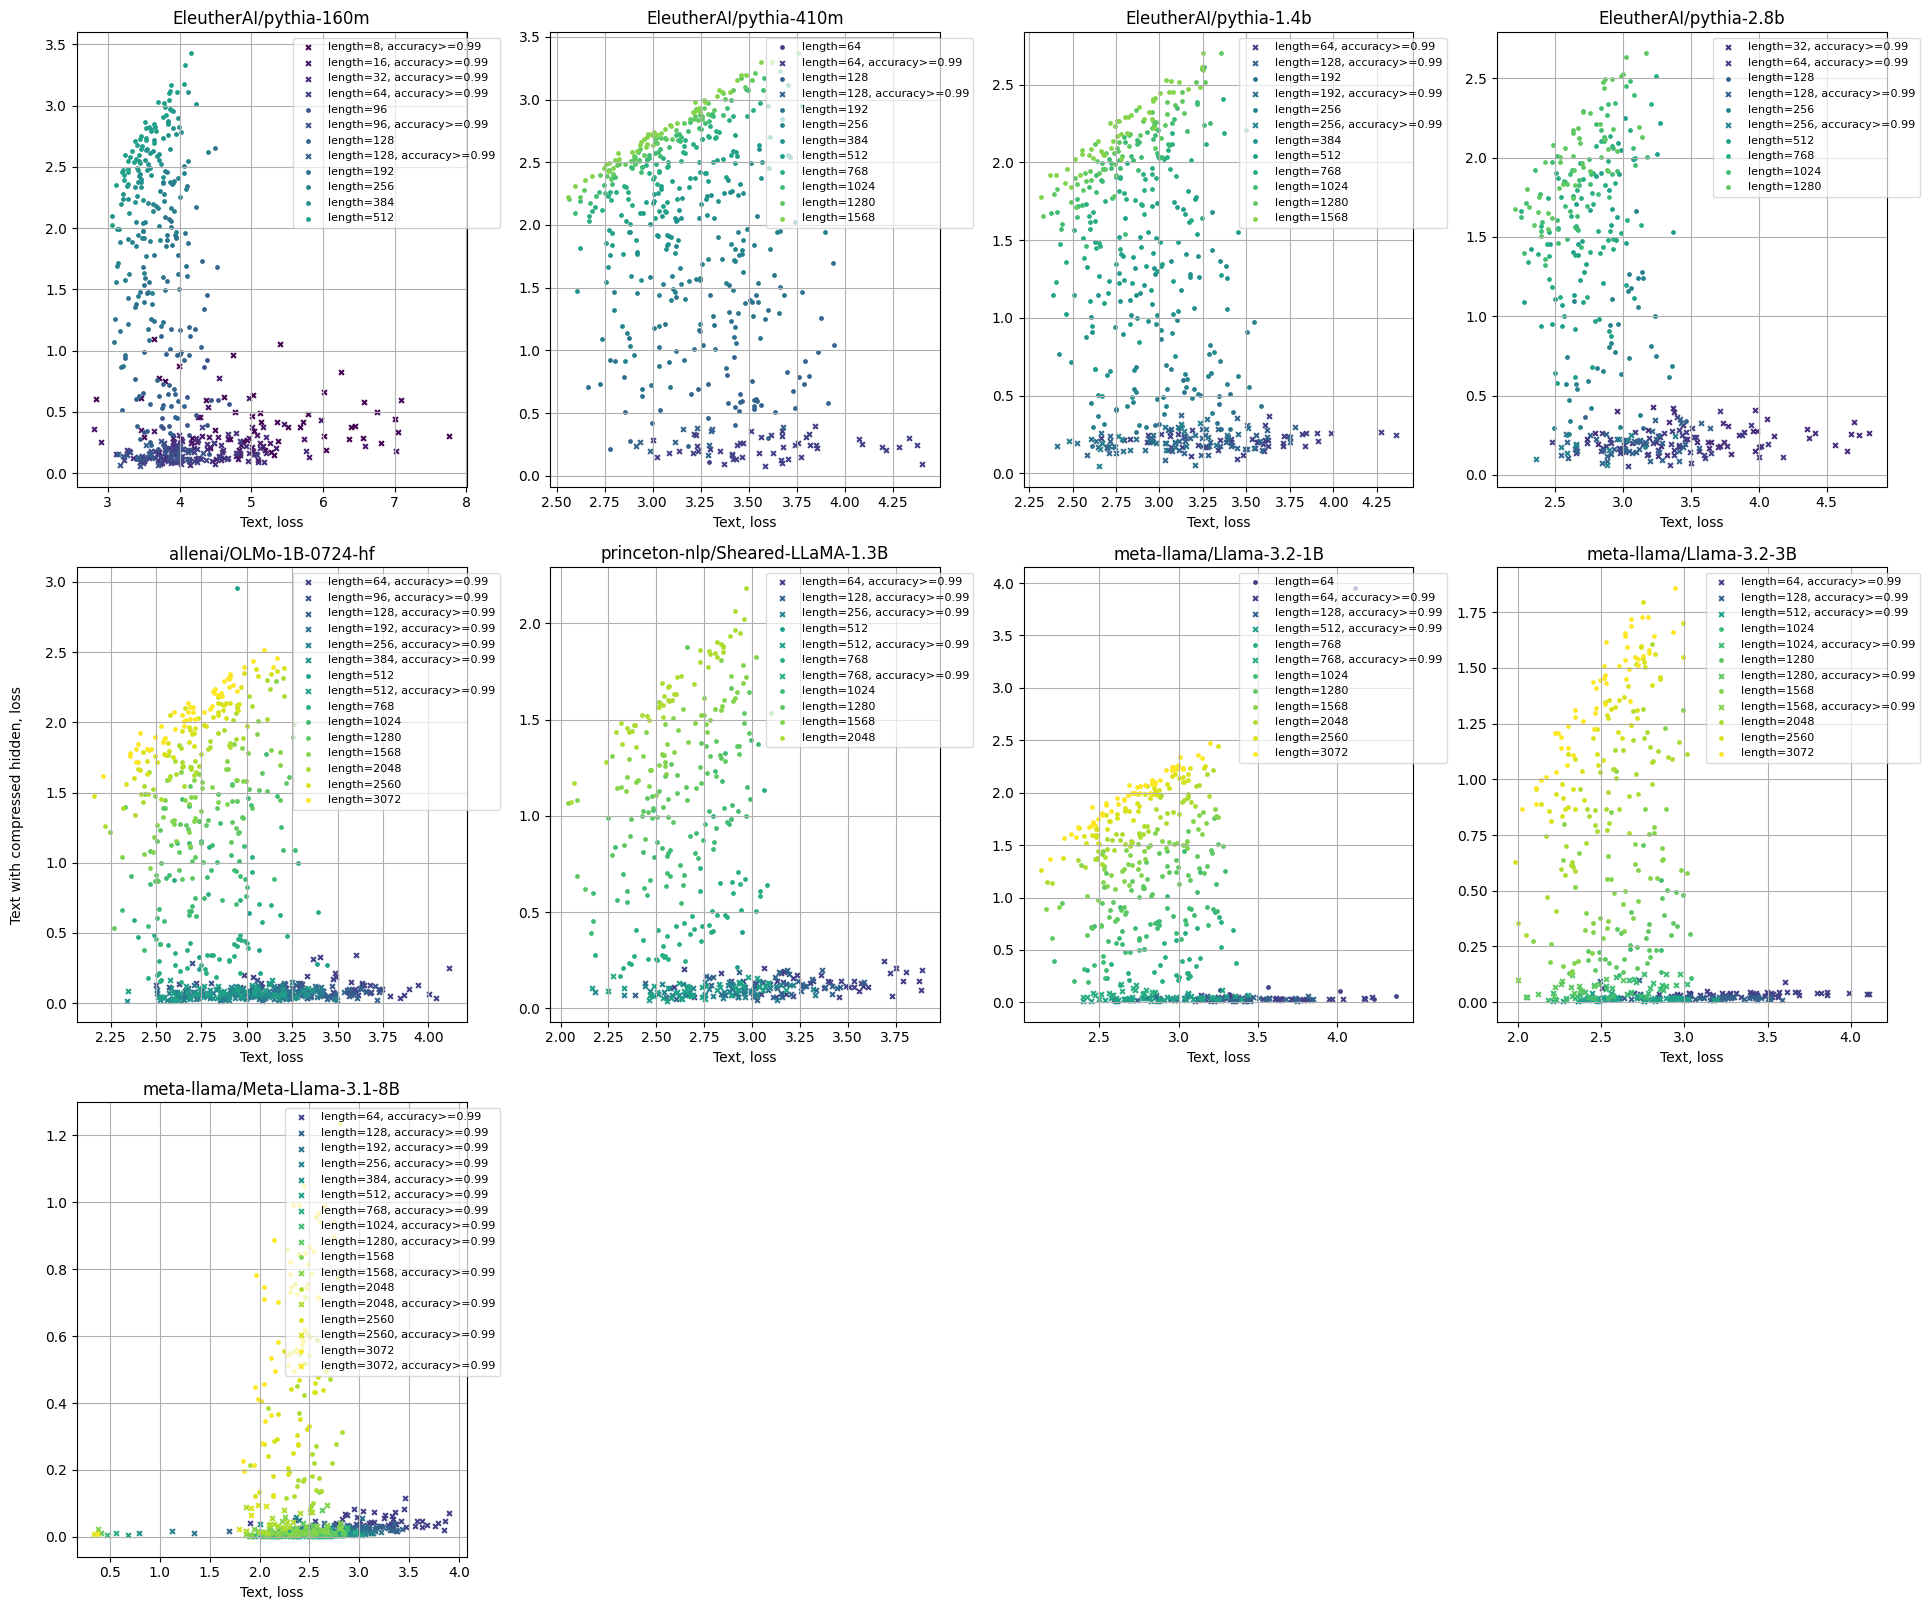

In [774]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
from transformers import AutoTokenizer

# List of models
# models = ['EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
#            'EleutherAI/pythia-2.8b',
#           'princeton-nlp/Sheared-LLaMA-1.3B',
#           'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B']
# max_lengths = [64, 96, 128, 192, 256, 384, 512, 768, 1024, 1280, 1568, 2048, 2560, 3072]
N_mem_tokens = 1

# Create subplots for each model
n_columns = 4
n_rows = (len(models) + n_columns - 1) // n_columns
fig, axes = plt.subplots(n_rows, n_columns, figsize=(20, 6 * n_rows),sharey=False,sharex=False)

s = 6
acc_thr = 0.99

# Define a global color map for max_lengths
max_lengths = sorted(all_models_df[all_models_df['shuffled']==False]['max_length'].unique())
colors = plt.cm.get_cmap('viridis', len(max_lengths))
global_color_map = {max_length: colors(i) for i, max_length in enumerate(max_lengths)}

data = []
for idx, model_name in enumerate(models):

    df = all_models_df[all_models_df['model_name'] == model_name]
    df = df[df['shuffled'] == False]
    if len(df) == 0:
        print(f'skipping {model_name}')
        continue

    # Split data based on best_accuracy threshold
    d_below_thr = df[df['best_accuracy'] < acc_thr]
    d_above_thr = df[df['best_accuracy'] >= acc_thr]

    # Extract data for fitting
    x_data = d_below_thr['original_loss'] * d_below_thr['max_length']
    y_data = d_below_thr['best_loss'] * d_below_thr['max_length']

    # Use curve_fit to fit the polynomial function to the data
    params, _ = curve_fit(polynomial, x_data, y_data)
    a, b = params

    # Generate values for the fitted curve
    x_fit = np.linspace(min(x_data) - 500, max(x_data) + 500, 500)
    y_fit = polynomial(x_fit, *params)

    # Define a colormap to assign consistent colors to each unique max_length
    colors = plt.cm.get_cmap('viridis', len(df['max_length'].unique()))
    color_map = {max_length: colors(i) for i, max_length in enumerate(df['max_length'].unique())}

    ax = axes.flat[idx]

    # Plot data points, grouped by max_length
    for max_length in sorted(df['max_length'].unique()):
        subset_below = d_below_thr[d_below_thr['max_length'] == max_length]
        subset_above = d_above_thr[d_above_thr['max_length'] == max_length]

        # Plot points below the accuracy threshold
        if len(subset_below) > 0:
            ax.scatter(
                subset_below['original_loss'], 
                subset_below['best_loss'],
                label=f'length={max_length}',
                s=s,
                color=global_color_map[max_length]
            )

        # Plot points above the accuracy threshold
        if len(subset_above) > 0:
            ax.scatter(
                subset_above['original_loss'], 
                subset_above['best_loss'],
                color=global_color_map[max_length],  # Use the same color as for the points below the threshold
                marker='x', 
                s=s * 2,
                label=f'length={max_length}, accuracy>={acc_thr}'
            )

    # Plot the fitted curve with formula in the legend
    formula_label = f'Fitted line: y = {a:.3f}x + {b:.1f}'
    # ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=formula_label)

    # Find the value of best_loss corresponding to the accuracy threshold
    best_loss_thr = (d_above_thr['best_loss'] * d_above_thr['max_length']).max()

    # Add a horizontal line for the best_loss threshold
    # ax.axhline(y=best_loss_thr, color='red', linestyle=':', linewidth=2, label=f'loss threshold for accuracy >= {acc_thr}')

    # Labels, legend, and grid for each subplot
    ax.set_xlabel('Text, loss')
    ax.set_title(f'{model_name}')
    ax.grid()

    # Move the legend outside of the plot for each subplot
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=8, frameon=True, fancybox=True, framealpha=0.7)
    


# Set common ylabel for all subplots
# axes[0,0].set_ylabel('Text loss with compressed hidden * length')

# Remove any empty subplots if there are fewer models than subplots
for idx in range(len(models), n_rows * n_columns):
    fig.delaxes(axes.flat[idx])

# Set common ylabel for all subplots
fig.text(0.04, 0.5, 'Text with compressed hidden, loss', va='center', rotation='vertical', fontsize=10)


plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Adjust layout to accommodate legends and labels properly
plt.show()


In [121]:
all_models_df['loss_diff']  = (all_models_df['original_loss'] - all_models_df['best_loss']) * all_models_df['max_length']

In [122]:
all_models_df

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,mem_dim,n_layers,vocab_size,n_att_heads,intermediate_size,token2bytes,loss_diff
0,EleutherAI/pythia-160m,8,1,4.882830,0.261007,1.000000,False,768,12,50304,12,3072,0.231407,36.974587
1,EleutherAI/pythia-160m,8,1,6.018319,0.304136,1.000000,False,768,12,50304,12,3072,0.231407,45.713460
2,EleutherAI/pythia-160m,8,1,3.802093,0.751129,1.000000,False,768,12,50304,12,3072,0.231407,24.407712
3,EleutherAI/pythia-160m,8,1,4.751411,0.964425,1.000000,False,768,12,50304,12,3072,0.231407,30.295889
4,EleutherAI/pythia-160m,8,1,5.125309,0.491976,1.000000,False,768,12,50304,12,3072,0.231407,37.066662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,meta-llama/Meta-Llama-3.1-8B,2560,1,2.811077,1.237334,0.731536,False,4096,32,128256,32,14336,0.229209,4028.781738
5146,meta-llama/Meta-Llama-3.1-8B,2560,1,2.499291,0.331149,0.951934,False,4096,32,128256,32,14336,0.229209,5550.442734
5147,meta-llama/Meta-Llama-3.1-8B,2560,1,2.331630,0.250187,0.964830,False,4096,32,128256,32,14336,0.229209,5328.493881
5148,meta-llama/Meta-Llama-3.1-8B,2560,1,1.989098,0.093757,0.991403,False,4096,32,128256,32,14336,0.229209,4852.071609


In [123]:
all_models_df[all_models_df['shuffled']==False].groupby('model_name').mean()['original_loss']

model_name
EleutherAI/pythia-1.4b              2.988536
EleutherAI/pythia-160m              4.043491
EleutherAI/pythia-2.8b              2.985090
EleutherAI/pythia-410m              3.220910
allenai/OLMo-1B-0724-hf             2.928677
meta-llama/Llama-3.2-1B             2.923181
meta-llama/Llama-3.2-3B             2.719957
meta-llama/Meta-Llama-3.1-8B        2.519377
princeton-nlp/Sheared-LLaMA-1.3B    2.788559
Name: original_loss, dtype: float64

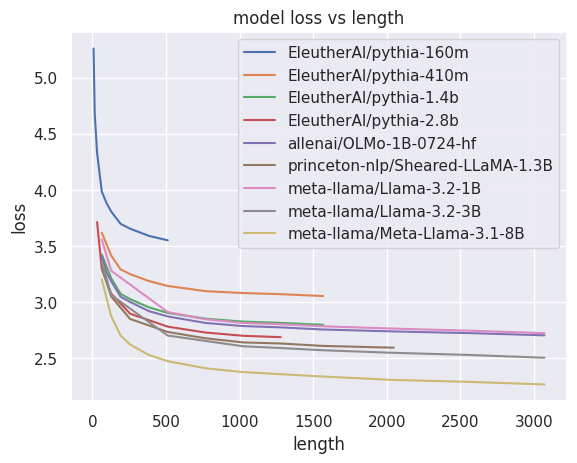

In [124]:
import seaborn as sns
pd.set_option('display.max_rows', 200)
sns.set_theme()
models_by_len_df = all_models_df[all_models_df['shuffled']==False].groupby(['model_name', 'max_length'], as_index=False).mean()
for model_name in models:
    model_df = models_by_len_df[models_by_len_df['model_name']==model_name]
    plt.plot(model_df['max_length'], model_df['original_loss'], label=model_name)
plt.title('model loss vs length')
plt.xlabel('length')
plt.ylabel('loss')
plt.legend()
plt.show()

In [125]:
all_models_df[all_models_df['shuffled']==False].groupby(['model_name', 'max_length'], as_index=False).mean()

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,mem_dim,n_layers,vocab_size,n_att_heads,intermediate_size,token2bytes,loss_diff
0,EleutherAI/pythia-1.4b,64,1.0,3.423044,0.211946,1.000000,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,205.510282
1,EleutherAI/pythia-1.4b,128,1.0,3.212652,0.206469,1.000000,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,384.791491
2,EleutherAI/pythia-1.4b,192,1.0,3.072988,0.265525,0.989424,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,539.032860
3,EleutherAI/pythia-1.4b,256,1.0,3.026844,0.488633,0.948157,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,649.782024
4,EleutherAI/pythia-1.4b,384,1.0,2.953935,1.044432,0.810287,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,733.249296
5,EleutherAI/pythia-1.4b,512,1.0,2.903877,1.395051,0.722074,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,772.518852
6,EleutherAI/pythia-1.4b,768,1.0,2.852595,1.793665,0.623494,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,813.258005
7,EleutherAI/pythia-1.4b,1024,1.0,2.826483,2.005273,0.574858,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,840.918811
8,EleutherAI/pythia-1.4b,1280,1.0,2.814907,2.113542,0.552995,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,897.747937
9,EleutherAI/pythia-1.4b,1568,1.0,2.798030,2.220856,0.528679,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,905.009697


In [126]:
models_by_len_df

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,mem_dim,n_layers,vocab_size,n_att_heads,intermediate_size,token2bytes,loss_diff
0,EleutherAI/pythia-1.4b,64,1.0,3.423044,0.211946,1.000000,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,205.510282
1,EleutherAI/pythia-1.4b,128,1.0,3.212652,0.206469,1.000000,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,384.791491
2,EleutherAI/pythia-1.4b,192,1.0,3.072988,0.265525,0.989424,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,539.032860
3,EleutherAI/pythia-1.4b,256,1.0,3.026844,0.488633,0.948157,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,649.782024
4,EleutherAI/pythia-1.4b,384,1.0,2.953935,1.044432,0.810287,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,733.249296
5,EleutherAI/pythia-1.4b,512,1.0,2.903877,1.395051,0.722074,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,772.518852
6,EleutherAI/pythia-1.4b,768,1.0,2.852595,1.793665,0.623494,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,813.258005
7,EleutherAI/pythia-1.4b,1024,1.0,2.826483,2.005273,0.574858,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,840.918811
8,EleutherAI/pythia-1.4b,1280,1.0,2.814907,2.113542,0.552995,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,897.747937
9,EleutherAI/pythia-1.4b,1568,1.0,2.798030,2.220856,0.528679,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,905.009697


In [127]:
all_models_df['original_loss_mean'] = all_models_df[all_models_df['shuffled']==False].groupby('model_name')['original_loss'].transform('mean')

In [128]:
models_by_len_df[(models_by_len_df['max_length'] == 512)&(models_by_len_df['model_name']=='EleutherAI/pythia-160m')]['original_loss'].item()

3.550559573173523

In [129]:
all_models_df['original_loss_mean_512'] = all_models_df.apply(lambda x: models_by_len_df[(models_by_len_df['max_length'] == 512)&(models_by_len_df['model_name']==x['model_name'])]['original_loss'].item(), axis=1)

In [130]:
# avg compression (reduce of entropy)
all_models_df[(all_models_df['shuffled']==False)&(all_models_df['best_accuracy']<0.98)].groupby('model_name').mean().sort_values('loss_diff')

,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,mem_dim,n_layers,vocab_size,n_att_heads,intermediate_size,token2bytes,loss_diff,original_loss_mean,original_loss_mean_512
model_name,,,,,,,,,,,,,,,
EleutherAI/pythia-160m,284.702290,1.0,3.692944,1.879739,0.654335,0.0,768.0,12.0,50304.0,12.0,3072.0,0.231407,399.200410,4.043491,3.550560
EleutherAI/pythia-410m,698.114943,1.0,3.177163,2.090131,0.588986,0.0,1024.0,24.0,50304.0,16.0,4096.0,0.231407,435.526612,3.220910,3.143882
EleutherAI/pythia-2.8b,791.663866,1.0,2.762771,1.585948,0.668654,0.0,2560.0,32.0,50304.0,32.0,10240.0,0.231407,757.918011,2.985090,2.781524
EleutherAI/pythia-1.4b,832.369942,1.0,2.893910,1.601535,0.675448,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,799.959554,2.988536,2.903877
princeton-nlp/Sheared-LLaMA-1.3B,1348.179592,1.0,2.637161,1.129507,0.767284,0.0,2048.0,24.0,32000.0,16.0,5504.0,0.253111,1839.350962,2.788559,2.734495
allenai/OLMo-1B-0724-hf,1754.880000,1.0,2.764697,1.436387,0.714820,0.0,2048.0,16.0,50304.0,16.0,8192.0,0.231407,1904.108376,2.928677,2.872495
meta-llama/Llama-3.2-1B,1835.851852,1.0,2.795957,1.400107,0.710229,0.0,2048.0,16.0,128256.0,32.0,8192.0,0.229209,2166.415350,2.923181,2.912045
meta-llama/Llama-3.2-3B,2193.076233,1.0,2.576071,0.942922,0.808916,0.0,3072.0,28.0,128256.0,24.0,8192.0,0.229209,3303.551531,2.719957,2.702343
meta-llama/Meta-Llama-3.1-8B,2702.222222,1.0,2.373223,0.536234,0.892589,0.0,4096.0,32.0,128256.0,32.0,14336.0,0.229209,4887.359183,2.519377,2.473942


In [131]:
all_models_df['C_mean'] = all_models_df[(all_models_df['shuffled']==True)&(all_models_df['best_accuracy']<0.98)].groupby('model_name')['loss_diff'].transform('mean')

In [132]:
# all_models_df['original_loss_mean_by_len'] = all_models_df.apply(lambda x: models_by_len_df[(models_by_len_df['model_name'] == x['model_name']) & (models_by_len_df['max_length'] == x['max_length'])]['original_loss'].item(), axis=1)


In [133]:
all_models_df

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,mem_dim,n_layers,vocab_size,n_att_heads,intermediate_size,token2bytes,loss_diff,original_loss_mean,original_loss_mean_512,C_mean
0,EleutherAI/pythia-160m,8,1,4.882830,0.261007,1.000000,False,768,12,50304,12,3072,0.231407,36.974587,4.043491,3.550560,NaN
1,EleutherAI/pythia-160m,8,1,6.018319,0.304136,1.000000,False,768,12,50304,12,3072,0.231407,45.713460,4.043491,3.550560,NaN
2,EleutherAI/pythia-160m,8,1,3.802093,0.751129,1.000000,False,768,12,50304,12,3072,0.231407,24.407712,4.043491,3.550560,NaN
3,EleutherAI/pythia-160m,8,1,4.751411,0.964425,1.000000,False,768,12,50304,12,3072,0.231407,30.295889,4.043491,3.550560,NaN
4,EleutherAI/pythia-160m,8,1,5.125309,0.491976,1.000000,False,768,12,50304,12,3072,0.231407,37.066662,4.043491,3.550560,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,meta-llama/Meta-Llama-3.1-8B,2560,1,2.811077,1.237334,0.731536,False,4096,32,128256,32,14336,0.229209,4028.781738,2.519377,2.473942,NaN
5146,meta-llama/Meta-Llama-3.1-8B,2560,1,2.499291,0.331149,0.951934,False,4096,32,128256,32,14336,0.229209,5550.442734,2.519377,2.473942,NaN
5147,meta-llama/Meta-Llama-3.1-8B,2560,1,2.331630,0.250187,0.964830,False,4096,32,128256,32,14336,0.229209,5328.493881,2.519377,2.473942,NaN
5148,meta-llama/Meta-Llama-3.1-8B,2560,1,1.989098,0.093757,0.991403,False,4096,32,128256,32,14336,0.229209,4852.071609,2.519377,2.473942,NaN


In [134]:
all_models_df['H_text']  = all_models_df['original_loss'] * all_models_df['max_length']
all_models_df['H_text|c']  = all_models_df['best_loss'] * all_models_df['max_length']
all_models_df['XXX'] = all_models_df['mem_dim'] * all_models_df['n_layers'] / all_models_df['original_loss_mean']
all_models_df

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,mem_dim,n_layers,vocab_size,n_att_heads,intermediate_size,token2bytes,loss_diff,original_loss_mean,original_loss_mean_512,C_mean,H_text,H_text|c,XXX
0,EleutherAI/pythia-160m,8,1,4.882830,0.261007,1.000000,False,768,12,50304,12,3072,0.231407,36.974587,4.043491,3.550560,NaN,39.062641,2.088054,2279.218516
1,EleutherAI/pythia-160m,8,1,6.018319,0.304136,1.000000,False,768,12,50304,12,3072,0.231407,45.713460,4.043491,3.550560,NaN,48.146549,2.433089,2279.218516
2,EleutherAI/pythia-160m,8,1,3.802093,0.751129,1.000000,False,768,12,50304,12,3072,0.231407,24.407712,4.043491,3.550560,NaN,30.416744,6.009033,2279.218516
3,EleutherAI/pythia-160m,8,1,4.751411,0.964425,1.000000,False,768,12,50304,12,3072,0.231407,30.295889,4.043491,3.550560,NaN,38.011288,7.715398,2279.218516
4,EleutherAI/pythia-160m,8,1,5.125309,0.491976,1.000000,False,768,12,50304,12,3072,0.231407,37.066662,4.043491,3.550560,NaN,41.002472,3.935810,2279.218516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,meta-llama/Meta-Llama-3.1-8B,2560,1,2.811077,1.237334,0.731536,False,4096,32,128256,32,14336,0.229209,4028.781738,2.519377,2.473942,NaN,7196.357422,3167.575684,52025.568489
5146,meta-llama/Meta-Llama-3.1-8B,2560,1,2.499291,0.331149,0.951934,False,4096,32,128256,32,14336,0.229209,5550.442734,2.519377,2.473942,NaN,6398.185425,847.742691,52025.568489
5147,meta-llama/Meta-Llama-3.1-8B,2560,1,2.331630,0.250187,0.964830,False,4096,32,128256,32,14336,0.229209,5328.493881,2.519377,2.473942,NaN,5968.973389,640.479507,52025.568489
5148,meta-llama/Meta-Llama-3.1-8B,2560,1,1.989098,0.093757,0.991403,False,4096,32,128256,32,14336,0.229209,4852.071609,2.519377,2.473942,NaN,5092.090759,240.019150,52025.568489


In [135]:
# ok, we found compression value for a single model (loss_diff) that is stable across all lengths.

# but how to generalize it across all models? use some model characteristic for it?

In [136]:
import seaborn as sns

/home/jovyan/envs/py3.11_pt2_cu11.8/lib/python3.11/site-packages/seaborn/relational.py:733: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


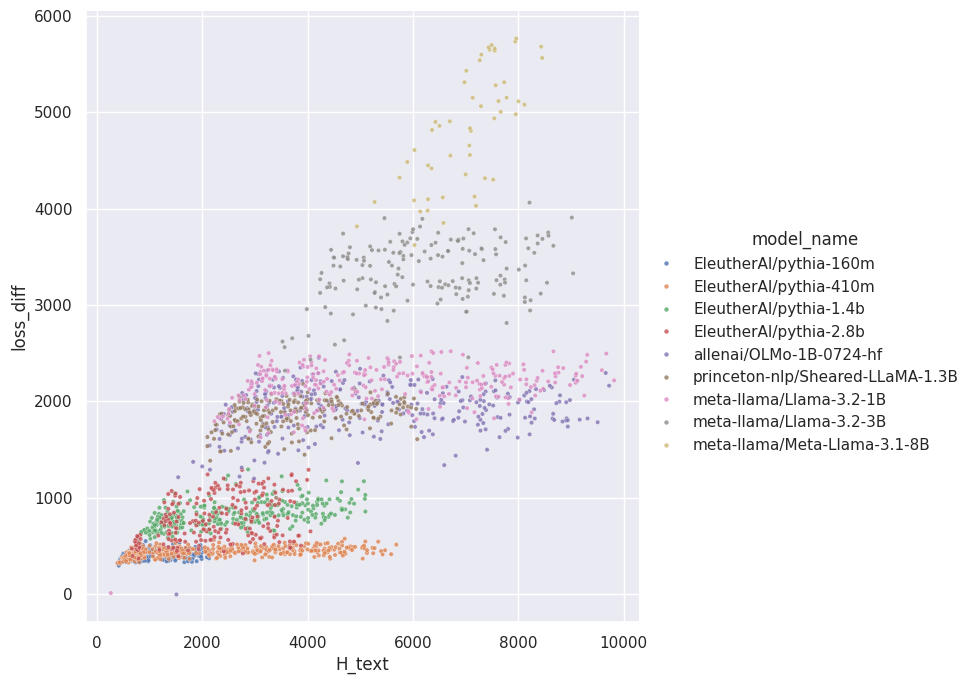

In [137]:
#&(all_models_df['model_name']=='EleutherAI/pythia-160m')
sns.relplot(ax=ax, data=all_models_df[(all_models_df['best_accuracy'] <=0.9 )&(all_models_df['shuffled'] == False)],
            x='H_text', y='loss_diff', hue='model_name', alpha=0.8, s=10, height=7)
plt.show()

In [138]:
# all texts that have H_text > C, now we want to find what is C
df = all_models_df[(all_models_df['best_accuracy'] <=0.9 )&(all_models_df['shuffled'] == False)]
df

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,mem_dim,n_layers,vocab_size,n_att_heads,intermediate_size,token2bytes,loss_diff,original_loss_mean,original_loss_mean_512,C_mean,H_text,H_text|c,XXX
214,EleutherAI/pythia-160m,96,1,4.344181,0.869704,0.852632,False,768,12,50304,12,3072,0.231407,333.549786,4.043491,3.550560,NaN,417.041382,83.491596,2279.218516
219,EleutherAI/pythia-160m,96,1,4.382999,0.924197,0.852632,False,768,12,50304,12,3072,0.231407,332.044979,4.043491,3.550560,NaN,420.767899,88.722919,2279.218516
250,EleutherAI/pythia-160m,192,1,3.524002,1.592297,0.706806,False,768,12,50304,12,3072,0.231407,370.887199,4.043491,3.550560,NaN,676.608307,305.721107,2279.218516
251,EleutherAI/pythia-160m,192,1,3.887244,2.055676,0.649215,False,768,12,50304,12,3072,0.231407,351.661057,4.043491,3.550560,NaN,746.350937,394.689880,2279.218516
252,EleutherAI/pythia-160m,192,1,3.187484,0.870290,0.842932,False,768,12,50304,12,3072,0.231407,444.901165,4.043491,3.550560,NaN,611.996887,167.095722,2279.218516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5129,meta-llama/Meta-Llama-3.1-8B,2560,1,2.455205,0.717596,0.836264,False,4096,32,128256,32,14336,0.229209,4448.277283,2.519377,2.473942,NaN,6285.324097,1837.046814,52025.568489
5131,meta-llama/Meta-Llama-3.1-8B,2560,1,2.354701,0.555095,0.887847,False,4096,32,128256,32,14336,0.229209,4606.990356,2.519377,2.473942,NaN,6028.033447,1421.043091,52025.568489
5139,meta-llama/Meta-Llama-3.1-8B,2560,1,2.301098,0.549771,0.885111,False,4096,32,128256,32,14336,0.229209,4483.398285,2.519377,2.473942,NaN,5890.811768,1407.413483,52025.568489
5145,meta-llama/Meta-Llama-3.1-8B,2560,1,2.811077,1.237334,0.731536,False,4096,32,128256,32,14336,0.229209,4028.781738,2.519377,2.473942,NaN,7196.357422,3167.575684,52025.568489


/tmp/ipykernel_3411812/3530517114.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['XXX'] = df['mem_dim'] / (df['original_loss'] * df['token2bytes'])
/tmp/ipykernel_3411812/3530517114.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss_diff_t2b'] = df['loss_diff'] * df['token2bytes']


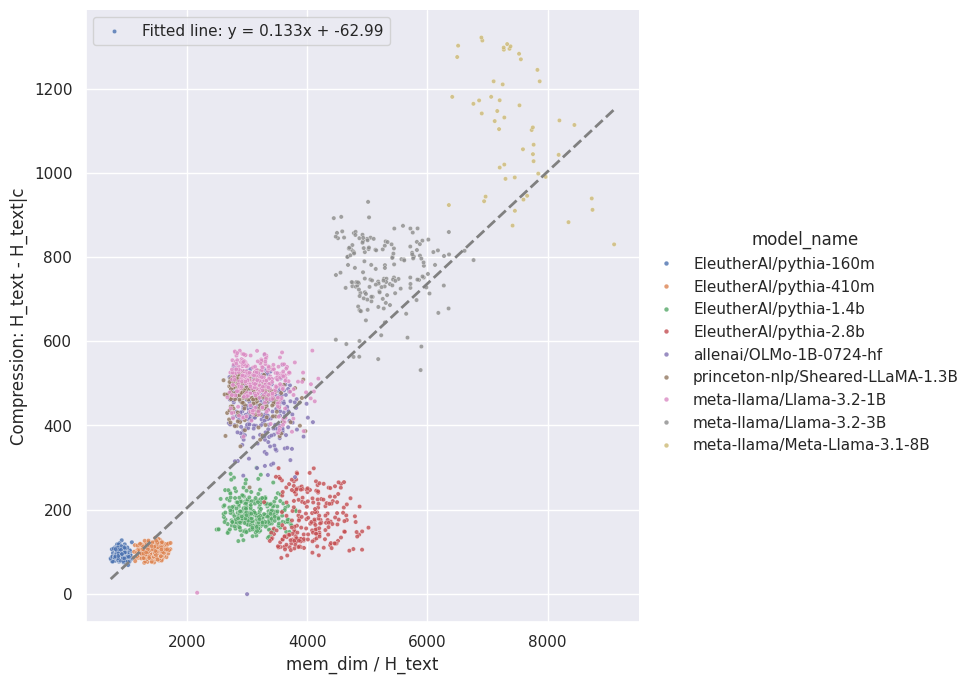

In [151]:
def polynomial(x, a, b):
    return a * x + b

# df['XXX'] = (1 / (df['original_loss'] - df['original_loss_mean']) * df['mem_dim'])
# adjust entropies to bits_per_byte
df['XXX'] = df['mem_dim'] / (df['original_loss'] * df['token2bytes'])
df['loss_diff_t2b'] = df['loss_diff'] * df['token2bytes']


x_data = df['XXX']
y_data = df['loss_diff_t2b']
# Use curve_fit to fit the polynomial function to the data
params, _ = curve_fit(polynomial, x_data, y_data)
a, b = params

# Generate values for the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 500)
y_fit = polynomial(x_fit, *params)


#&(all_models_df['model_name']=='EleutherAI/pythia-160m')
p = sns.relplot(data=df,#[df['model_name']=='EleutherAI/pythia-160m'],
            x='XXX', y='loss_diff_t2b', hue='model_name', alpha=0.8, s=10, height=7)

formula_label = f'Fitted line: y = {a:.3f}x + {b:.2f}'
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.plot(x_fit, y_fit, color='grey', linestyle='--', linewidth=2, label=formula_label)
plt.legend(labels=[formula_label])

plt.xlabel('mem_dim / H_text')
plt.ylabel('Compression: H_text - H_text|c')

plt.show()

In [140]:
models_by_len_df[models_by_len_df['max_length'] == 512].sort_values('original_loss', ascending=False)

,model_name,max_length,n_mem_tokens,original_loss,best_loss,best_accuracy,shuffled,mem_dim,n_layers,vocab_size,n_att_heads,intermediate_size,token2bytes,loss_diff
19,EleutherAI/pythia-160m,512,1.0,3.550560,2.751692,0.478121,0.0,768.0,12.0,50304.0,12.0,3072.0,0.231407,409.020447
33,EleutherAI/pythia-410m,512,1.0,3.143882,2.285589,0.540978,0.0,1024.0,24.0,50304.0,16.0,4096.0,0.231407,439.446136
54,meta-llama/Llama-3.2-1B,512,1.0,2.912045,0.039908,0.997847,0.0,2048.0,16.0,128256.0,32.0,8192.0,0.229209,1470.534372
5,EleutherAI/pythia-1.4b,512,1.0,2.903877,1.395051,0.722074,0.0,2048.0,24.0,50304.0,16.0,8192.0,0.231407,772.518852
44,allenai/OLMo-1B-0724-hf,512,1.0,2.872495,0.176639,0.979139,0.0,2048.0,16.0,50304.0,16.0,8192.0,0.231407,1380.278450
24,EleutherAI/pythia-2.8b,512,1.0,2.781524,1.376212,0.718200,0.0,2560.0,32.0,50304.0,32.0,10240.0,0.231407,719.519570
87,princeton-nlp/Sheared-LLaMA-1.3B,512,1.0,2.734495,0.102000,0.997378,0.0,2048.0,24.0,32000.0,16.0,5504.0,0.253111,1347.837448
64,meta-llama/Llama-3.2-3B,512,1.0,2.702343,0.014691,0.998434,0.0,3072.0,28.0,128256.0,24.0,8192.0,0.229209,1376.078252
76,meta-llama/Meta-Llama-3.1-8B,512,1.0,2.473942,0.007466,0.999883,0.0,4096.0,32.0,128256.0,32.0,14336.0,0.229209,1262.835751


In [39]:
df.groupby(['model_name', 'max_length']).aggregate('mean')['loss_diff']

model_name                        max_length
EleutherAI/pythia-1.4b            256            612.593728
                                  384            724.097241
                                  512            767.828033
                                  768            813.258005
                                  1024           840.918811
                                  1280           897.747937
                                  1568           905.009697
EleutherAI/pythia-160m            96             332.797382
                                  128            373.516172
                                  192            404.108101
                                  256            403.140579
                                  384            408.158657
                                  512            409.020447
EleutherAI/pythia-2.8b            256            509.543275
                                  512            713.959942
                                  768            802.64